# Produce the IR maps for GEM 2021

In [1]:
# Imports
import ag3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import matplotlib.patheffects as PathEffects

/opt/conda/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Get the sample metadata for all of the wild sample sets

In [2]:
# Get the ag3 data
ag3_data = ag3.release_data()

In [3]:
# Get the list of all the wild sample sets
sample_sets = ag3_data.all_wild_sample_sets

In [4]:
# Eyeball the list of sample sets
sample_sets

['AG1000G-AO',
 'AG1000G-BF-A',
 'AG1000G-BF-B',
 'AG1000G-BF-C',
 'AG1000G-CD',
 'AG1000G-CF',
 'AG1000G-CI',
 'AG1000G-CM-A',
 'AG1000G-CM-B',
 'AG1000G-CM-C',
 'AG1000G-FR',
 'AG1000G-GA-A',
 'AG1000G-GH',
 'AG1000G-GM-A',
 'AG1000G-GM-B',
 'AG1000G-GM-C',
 'AG1000G-GN-A',
 'AG1000G-GN-B',
 'AG1000G-GQ',
 'AG1000G-GW',
 'AG1000G-KE',
 'AG1000G-ML-A',
 'AG1000G-ML-B',
 'AG1000G-MW',
 'AG1000G-MZ',
 'AG1000G-TZ',
 'AG1000G-UG']

In [11]:
# # Get the metadata for all samples in these sample sets
# sample_meta = ag3_data.load_sample_set_metadata(sample_sets)

In [12]:
sample_meta = pd.read_csv('../data/insecticide_resistance_genotype_table.csv')

In [13]:
# Eyeball some of the sample metadata
sample_meta

sample_id partner_sample_id      contributor country location  year  \
0     AR0047-C            LUA047       Joao Pinto  Angola   Luanda  2009   
1     AR0049-C            LUA049       Joao Pinto  Angola   Luanda  2009   
2     AR0051-C            LUA051       Joao Pinto  Angola   Luanda  2009   
3     AR0061-C            LUA061       Joao Pinto  Angola   Luanda  2009   
4     AR0078-C            LUA078       Joao Pinto  Angola   Luanda  2009   
...        ...               ...              ...     ...      ...   ...   
2778  AC0295-C               K92  Martin Donnelly  Uganda   Kihihi  2012   
2779  AC0296-C               K93  Martin Donnelly  Uganda   Kihihi  2012   
2780  AC0297-C               K94  Martin Donnelly  Uganda   Kihihi  2012   
2781  AC0298-C               K95  Martin Donnelly  Uganda   Kihihi  2012   
2782  AC0299-C               K96  Martin Donnelly  Uganda   Kihihi  2012   

      month  latitude  longitude sex_call  ... Gste2 Gste3  Gste4  Gste5  \
0         4    -8.884     13.302        F  ...     0     0      0      0   
1         4    -8.884     13.302        F  ...     1     1      1      1   
2         4    -8.884     13.302        F  ...     0     0      0      0   
3         4    -8.884     13.302        F  ...     0     0      0      0   
4         4    -8.884     13.302        F  ...     0     0      0      0   
...     ...       ...        ...      ...  ...   ...   ...    ...    ...   
2778     11    -0.751     29.701        F  ...     0     0      0      0   
2779     11    -0.751     29.701        F  ...     0     0      0      0   
2780     11    -0.751     29.701        F  ...     0     0      0      0   
2781     11    -0.751     29.701        F  ...     0     0      0      0   
2782     11    -0.751     29.701        F  ...     0     0      0      0   

     Gste6 Gste7 Gstu4  Max_Gstue  Cyp9k1  any_cyp  
0        0     0     0          0       0    False  
1        1     1     1          1       1     True  
2        0     0     0          0       0    False  
3        0     0     0          0       0    False  
4        0     0     0          0       0    False  
...    ...   ...   ...        ...     ...      ...  
2778     0     0     0          0       1     True  
2779     0     0     0          0       2     True  
2780     0     0     0          0       2     True  
2781     0     0     0          0       1     True  
2782     0     0     0          0       0    False  

[2783 rows x 52 columns]

In [8]:
sample_meta.columns

Index(['sample_id', 'partner_sample_id', 'contributor', 'country', 'location',
       'year', 'month', 'latitude', 'longitude', 'sex_call', 'sample_set',
       'release', 'aim_fraction_colu', 'aim_fraction_arab',
       'species_gambcolu_arabiensis', 'species_gambiae_coluzzii', 'species',
       'kdr_S', 'kdr_F', 'any_kdr', 'kdr_1570', 'ace_119s', 'gst_114t', 'sex',
       'high.var', 'Ace1', 'Cyp6aa1', 'Cyp6aa2', 'Cyp6p1', 'Cyp6p2', 'Cyp6p3',
       'Cyp6p4', 'Cyp6p5', 'Max_Cyp6aap', 'Cyp6m2', 'Cyp6m3', 'Cyp6m4',
       'Cyp6z1', 'Cyp6z2', 'Cyp6z3', 'Max_Cyp6mz', 'Gste1', 'Gste2', 'Gste3',
       'Gste4', 'Gste5', 'Gste6', 'Gste7', 'Gstu4', 'Max_Gstue', 'Cyp9k1',
       'any_cyp'],
      dtype='object')

## we are going make three maps, one for each species to compare/contrast 
- split the meta into three, we'll leave out the intermediates for now

In [15]:
sample_meta.species.unique()

array(['coluzzii', 'gambiae', 'intermediate_gambiae_coluzzii',
       'arabiensis'], dtype=object)

In [18]:
sample_meta_gamb = sample_meta[sample_meta.species == "gambiae"].copy()
sample_meta_colu = sample_meta[sample_meta.species == "coluzzii"].copy()
sample_meta_arab = sample_meta[sample_meta.species == "arabiensis"].copy()

In [20]:
# Eyeball the number of metadata records (i.e. samples) for each sample set
sample_meta_gamb.sample_set.value_counts()

AG1000G-CM-A    303
AG1000G-UG      207
AG1000G-GN-B    148
AG1000G-BF-A     98
AG1000G-CM-B     90
AG1000G-CD       76
AG1000G-MZ       74
AG1000G-GA-A     69
AG1000G-TZ       68
AG1000G-GM-A     58
AG1000G-CF       55
AG1000G-BF-B     46
AG1000G-GN-A     40
AG1000G-GH       36
AG1000G-ML-B     33
AG1000G-ML-A     33
AG1000G-GW       29
AG1000G-KE       28
AG1000G-CM-C     23
AG1000G-FR       23
AG1000G-BF-C     13
AG1000G-GQ       10
AG1000G-GM-B      9
AG1000G-GM-C      2
Name: sample_set, dtype: int64

In [21]:
sample_meta_colu.sample_set.value_counts()

AG1000G-GM-C    148
AG1000G-BF-A     82
AG1000G-AO       81
AG1000G-CI       80
AG1000G-GH       64
AG1000G-BF-B     53
AG1000G-ML-B     36
AG1000G-GN-B     35
AG1000G-ML-A     27
AG1000G-CM-C     19
AG1000G-CF       18
AG1000G-GM-B     16
AG1000G-CM-B      7
AG1000G-GM-A      5
AG1000G-GN-A      4
Name: sample_set, dtype: int64

In [22]:
sample_meta_arab.sample_set.value_counts()

AG1000G-TZ      225
AG1000G-UG       82
AG1000G-MW       41
AG1000G-KE       13
AG1000G-BF-B      3
AG1000G-CM-C      2
AG1000G-ML-B      2
Name: sample_set, dtype: int64

### See which sample sets contain samples from more than 1 country

In [23]:
# # Crosstab the sample_set ids with their countries, to count the number of samples in each country for each sample set
# sample_set_by_country = pd.crosstab(sample_meta.sample_set, sample_meta.country)
# sample_set_by_country.head()

In [24]:
# # Eyeball sample sets that have samples in multiple countries
# # `sample_set_by_country > 0` is true where a sample set has samples in that country,
# # so this sums the number of trues per row, and returns those that have > 1, i.e. samples for more than 1 country 
# sample_set_by_country.loc[(sample_set_by_country > 0).sum(axis=1) > 1]

### Convert the lat, long of all of the Mayotte sample metadata into the mean value, so that they are treated as one site, and represented as one pie on the map

In [25]:
sample_meta_gamb.loc[(sample_meta_gamb.country == 'Mayotte'),'latitude'] = sample_meta_gamb[sample_meta_gamb.country == 'Mayotte'].latitude.mean()
sample_meta_gamb.loc[(sample_meta_gamb.country == 'Mayotte'),'longitude'] = sample_meta_gamb[sample_meta_gamb.country == 'Mayotte'].longitude.mean()
sample_meta_gamb[sample_meta_gamb.country == 'Mayotte'].head()

sample_id partner_sample_id     contributor  country  \
1050  AP0007-C                60  Igor Sharakhov  Mayotte   
1051  AP0021-C                92  Igor Sharakhov  Mayotte   
1052  AP0019-C                88  Igor Sharakhov  Mayotte   
1053  AP0020-C                78  Igor Sharakhov  Mayotte   
1054  AP0009-C                62  Igor Sharakhov  Mayotte   

                      location  year  month   latitude  longitude sex_call  \
1050  Mtsamboro Forest Reserve  2011     -1 -12.857087  45.137435        F   
1051             Karihani Lake  2011     -1 -12.857087  45.137435        F   
1052          Mtsanga Charifou  2011     -1 -12.857087  45.137435        M   
1053          Mtsanga Charifou  2011     -1 -12.857087  45.137435        M   
1054                   Combani  2011     -1 -12.857087  45.137435        M   

      ... Gste2 Gste3  Gste4  Gste5 Gste6 Gste7 Gstu4  Max_Gstue  Cyp9k1  \
1050  ...     0     0      0      0     0     0     0          0       0   
1051  ...     0     0      0      0     0     0     0          0       0   
1052  ...     0     0      0      0     0     0     0          0       0   
1053  ...     0     0      0      0     0     0     0          0       0   
1054  ...     0     0      0      0     0     0     0          0       0   

      any_cyp  
1050    False  
1051    False  
1052     True  
1053    False  
1054     True  

[5 rows x 52 columns]

### Amend country names for map presentation and data-alignment

In [26]:
sample_meta_gamb.country = sample_meta_gamb.country.str.replace("Gambia, The", "The Gambia").str.replace("Equatorial Guinea", "Bioko")
sample_meta_colu.country = sample_meta_colu.country.str.replace("Gambia, The", "The Gambia").str.replace("Equatorial Guinea", "Bioko")

In [27]:
# Eyeball the amended country names
sample_meta_gamb.country.unique()

array(['Burkina Faso', 'Democratic Republic of Congo',
       'Central African Republic', 'Cameroon', 'Mayotte', 'Gabon',
       'Ghana', 'The Gambia', 'Guinea', 'Mali', 'Bioko', 'Guinea-Bissau',
       'Kenya', 'Mozambique', 'Tanzania', 'Uganda'], dtype=object)

In [28]:
sample_meta_colu.country.unique()

array(['Angola', 'Burkina Faso', 'Central African Republic',
       "Cote d'Ivoire", 'Cameroon', 'Ghana', 'The Gambia', 'Guinea',
       'Mali'], dtype=object)

In [29]:
sample_meta_arab.country.unique()

array(['Burkina Faso', 'Cameroon', 'Kenya', 'Mali', 'Malawi', 'Tanzania',
       'Uganda'], dtype=object)

In [ ]:
dsghdklsglkklg 

## Define the sites as samples with the same latitude and longitude

In [16]:
# Get the sample counts by site, where a site is a unique lat, long. Include country for reference.
sites = sample_meta.groupby(['latitude', 'longitude', 'country']).size().reset_index(name='nsamples')

In [17]:
# Eyeball the number of samples in each site
sites

latitude  longitude     country  nsamples
0   -23.716000  35.299000  Mozambique        74
1   -15.933000  34.755000      Malawi        41
2   -12.857087  45.137435     Mayotte        23
3    -8.884000  13.302000      Angola        81
4    -4.940000  38.948000    Tanzania        43
..         ...        ...         ...       ...
113  13.417000 -16.033000  The Gambia        19
114  13.550000 -15.900000  The Gambia        74
115  13.550000 -15.617000  The Gambia         1
116  13.567000 -14.917000  The Gambia       174
117  13.583000 -15.900000  The Gambia        11

[118 rows x 4 columns]

### Assign each site a unique identifier (short-hand for the unique map coordinates)

In [18]:
# Name the index 'site_id', effectively assigning a unique identifier to each site
sites.index.name = 'site_id'

In [19]:
# Eyeball the site ids
sites

latitude  longitude     country  nsamples
site_id                                            
0       -23.716000  35.299000  Mozambique        74
1       -15.933000  34.755000      Malawi        41
2       -12.857087  45.137435     Mayotte        23
3        -8.884000  13.302000      Angola        81
4        -4.940000  38.948000    Tanzania        43
...            ...        ...         ...       ...
113      13.417000 -16.033000  The Gambia        19
114      13.550000 -15.900000  The Gambia        74
115      13.550000 -15.617000  The Gambia         1
116      13.567000 -14.917000  The Gambia       174
117      13.583000 -15.900000  The Gambia        11

[118 rows x 4 columns]

In [20]:
# Eyeball the sites sorted by nsamples (this doesn't change the df)
sites.sort_values('nsamples')

latitude  longitude       country  nsamples
site_id                                             
76          9.703     13.859      Cameroon         1
45          6.915     13.132      Cameroon         1
78          9.765     13.950      Cameroon         1
25          4.166     11.535      Cameroon         1
59          8.476     13.644      Cameroon         1
...           ...        ...           ...       ...
28          4.341     13.558      Cameroon       110
97         11.233     -4.472  Burkina Faso       128
7          -1.962     31.651      Tanzania       170
116        13.567    -14.917    The Gambia       174
11          0.770     34.026        Uganda       193

[118 rows x 4 columns]

## Separate out the sites that do not have many samples

In [21]:
# Get the subset of sites with nsamples >= cutoff
site_nsamples_cutoff = 10
sites_with_many_samples = sites[sites.nsamples >= site_nsamples_cutoff].copy()

In [22]:
# Eyeball the subset df
sites_with_many_samples.head()

latitude  longitude     country  nsamples
site_id                                            
0       -23.716000  35.299000  Mozambique        74
1       -15.933000  34.755000      Malawi        41
2       -12.857087  45.137435     Mayotte        23
3        -8.884000  13.302000      Angola        81
4        -4.940000  38.948000    Tanzania        43

In [23]:
# Eyeball the number of unique lats and longs, for the sites with nsamples >= cutoff
print('Num. sites with nsamples >= cutoff:', len(sites_with_many_samples))
print('Num. unique latitudes:', len(sites_with_many_samples.latitude.unique()))
print('Num. unique longitudes:', len(sites_with_many_samples.longitude.unique()))

Num. sites with nsamples >= cutoff: 43
Num. unique latitudes: 43
Num. unique longitudes: 42


## Get the metadata for sites with many samples 

In [24]:
# Get the sample metadata for the subset of sites with nsamples >= cutoff, preserving species call columns
sample_meta_for_sites_with_many_samples = sample_meta.merge(sites_with_many_samples.reset_index()[['longitude','latitude','site_id']])

In [25]:
# Eyeball some of the data
sample_meta_for_sites_with_many_samples

sample_id partner_sample_id      contributor country location  year  \
0     AR0047-C            LUA047       Joao Pinto  Angola   Luanda  2009   
1     AR0049-C            LUA049       Joao Pinto  Angola   Luanda  2009   
2     AR0051-C            LUA051       Joao Pinto  Angola   Luanda  2009   
3     AR0061-C            LUA061       Joao Pinto  Angola   Luanda  2009   
4     AR0078-C            LUA078       Joao Pinto  Angola   Luanda  2009   
...        ...               ...              ...     ...      ...   ...   
2615  AC0295-C               K92  Martin Donnelly  Uganda   Kihihi  2012   
2616  AC0296-C               K93  Martin Donnelly  Uganda   Kihihi  2012   
2617  AC0297-C               K94  Martin Donnelly  Uganda   Kihihi  2012   
2618  AC0298-C               K95  Martin Donnelly  Uganda   Kihihi  2012   
2619  AC0299-C               K96  Martin Donnelly  Uganda   Kihihi  2012   

      month  latitude  longitude sex_call  ... Gste3 Gste4  Gste5  Gste6  \
0         4    -8.884     13.302        F  ...     0     0      0      0   
1         4    -8.884     13.302        F  ...     1     1      1      1   
2         4    -8.884     13.302        F  ...     0     0      0      0   
3         4    -8.884     13.302        F  ...     0     0      0      0   
4         4    -8.884     13.302        F  ...     0     0      0      0   
...     ...       ...        ...      ...  ...   ...   ...    ...    ...   
2615     11    -0.751     29.701        F  ...     0     0      0      0   
2616     11    -0.751     29.701        F  ...     0     0      0      0   
2617     11    -0.751     29.701        F  ...     0     0      0      0   
2618     11    -0.751     29.701        F  ...     0     0      0      0   
2619     11    -0.751     29.701        F  ...     0     0      0      0   

     Gste7 Gstu4 Max_Gstue  Cyp9k1  any_cyp  site_id  
0        0     0         0       0    False        3  
1        1     1         1       1     True        3  
2        0     0         0       0    False        3  
3        0     0         0       0    False        3  
4        0     0         0       0    False        3  
...    ...   ...       ...     ...      ...      ...  
2615     0     0         0       1     True        9  
2616     0     0         0       2     True        9  
2617     0     0         0       2     True        9  
2618     0     0         0       1     True        9  
2619     0     0         0       0    False        9  

[2620 rows x 53 columns]

In [26]:
# Eyeball the number of unique lats and longs, for the sites with nsamples >= cutoff
print('Num. unique latitudes:', len(sample_meta_for_sites_with_many_samples.latitude.unique()))
print('Num. unique longitudes:', len(sample_meta_for_sites_with_many_samples.longitude.unique()))

Num. unique latitudes: 43
Num. unique longitudes: 42


In [28]:
sample_meta_for_sites_with_many_samples.columns

Index(['sample_id', 'partner_sample_id', 'contributor', 'country', 'location',
       'year', 'month', 'latitude', 'longitude', 'sex_call', 'sample_set',
       'release', 'aim_fraction_colu', 'aim_fraction_arab',
       'species_gambcolu_arabiensis', 'species_gambiae_coluzzii', 'species',
       'kdr_S', 'kdr_F', 'any_kdr', 'kdr_1570', 'ace_119s', 'gst_114t', 'sex',
       'high.var', 'Ace1', 'Cyp6aa1', 'Cyp6aa2', 'Cyp6p1', 'Cyp6p2', 'Cyp6p3',
       'Cyp6p4', 'Cyp6p5', 'Max_Cyp6aap', 'Cyp6m2', 'Cyp6m3', 'Cyp6m4',
       'Cyp6z1', 'Cyp6z2', 'Cyp6z3', 'Max_Cyp6mz', 'Gste1', 'Gste2', 'Gste3',
       'Gste4', 'Gste5', 'Gste6', 'Gste7', 'Gstu4', 'Max_Gstue', 'Cyp9k1',
       'any_cyp', 'site_id'],
      dtype='object')

## get the resistance 'status' for sites with many samples

In [46]:
def status(row):
    if row.any_kdr == False:
        if row.any_cyp == False:
            return "none"
        if row.any_cyp == True:
            return "cyp"
    if row.any_kdr == True:
        if row.any_cyp == False:
            return "kdr"
        if row.any_cyp == True:
            return "both"

In [50]:
sample_meta_for_sites_with_many_samples['pyrethroid_ir'] = sample_meta_for_sites_with_many_samples.apply (lambda row: status(row), axis=1)

In [51]:
kdr_call = pd.crosstab(sample_meta_for_sites_with_many_samples.site_id, sample_meta_for_sites_with_many_samples.pyrethroid_ir)
kdr_call

pyrethroid_ir  both  cyp  kdr  none
site_id                            
0                 0   13    0    61
1                 0   16    0    25
2                 0    5    0    18
3                16    1   62     2
4                 3    6   18    16
5                 4    1   45    36
6                 0    2    0    38
7                31   19    1   119
8                 0    6    0    41
9                87    0    8     1
10                2    0   67     0
11               91   11   21    70
19                0    0    0    10
23                1    0    9     0
26               64    0   12     0
28               10    1   90     9
29                1    3   23    46
30               15    2   68    11
31                4    0   19     1
34                8    0   17     0
35                9    0   17     1
36                1    0   11     0
37               15    0   67    15
39               78    0    2     0
40               12    0   11     1
60               67    0    7     0
72               52    0   10     0
95               61    0    2     0
96               73    1    3     0
97              115    0   13     0
98               74    0    4     0
99               24    2    4     1
100               0    4    1    18
101               0   14    0    46
102               0    5    0    28
103               0    1    2    10
109              32    0    8     0
110               8    1    4     0
112               0    6    0    14
113               0    1    0    18
114               0   44    0    30
116               3   20    4   147
117               0    0    0    11

In [78]:
kdr_call.loc[0]

pyrethroid_ir
both     0
cyp     13
kdr      0
none    61
Name: 0, dtype: int64

## Prepare the list of country names for the map(s)

In [56]:
# Get the countries as a list
countries = list(sample_meta.country.unique())

In [57]:
# Eyeball the list of countries
countries

['Angola',
 'Burkina Faso',
 'Democratic Republic of Congo',
 'Central African Republic',
 "Cote d'Ivoire",
 'Cameroon',
 'Mayotte',
 'Gabon',
 'Ghana',
 'The Gambia',
 'Guinea',
 'Mali',
 'Bioko',
 'Guinea-Bissau',
 'Kenya',
 'Malawi',
 'Mozambique',
 'Tanzania',
 'Uganda']

In [58]:
country_names_as_multiline = {
    "Bioko": "Bioko island".replace(" ", "\n"),
    "Central African Republic": "Central African Republic".replace(" ", "\n"),
    "Cote d'Ivoire": "Cote d'Ivoire".replace(" ", "\n"),
    "Democratic Republic of Congo": "Democratic\nRepublic\nof Congo",
    "Guinea-Bissau": "Guinea- Bissau".replace(" ", "\n"),
    "Mayotte":"Mayotte island".replace(" ", "\n")
}

## Get the country centres (lat, lon) for the map labels

In [59]:
df_centroids = pd.read_csv("../data/Africa_centroids.csv")
df_centroids.head()

name_long   pop_est  gdp_md_est  lastcensus  Longitude   Latitude
0        Angola  12799293    110300.0        1970  17.537368 -12.293361
1       Burundi   8988091      3102.0        2008  29.875122  -3.359397
2         Benin   8791832     12830.0        2002   2.327853   9.641760
3  Burkina Faso  15746232     17820.0        2006  -1.754566  12.269538
4      Botswana   1990876     27060.0        2011  23.798534 -22.184032

In [60]:
# Lowercase the columns (e.g. Longitude => longitude)
df_centroids.columns = map(str.lower, df_centroids.columns)
df_centroids.columns

Index(['name_long', 'pop_est', 'gdp_md_est', 'lastcensus', 'longitude',
       'latitude'],
      dtype='object')

## Specify offsets for the country labels, using a copy of the country centres

In [61]:
# Check that the country identifiers are aligned
print('Number of countries:', len(countries))
print('Number of matching countries:', df_centroids['name_long'].isin(countries).sum())

Number of countries: 19
Number of matching countries: 19


In [62]:
# Get a copy of the country centres, only for the list of countries
# Set the index to name_long, so we can use df.loc[label]
country_metadata = df_centroids[df_centroids['name_long'].isin(countries)].copy().set_index('name_long')
country_metadata

pop_est  gdp_md_est  lastcensus  longitude  \
name_long                                                                   
Angola                        12799293    110300.0        1970  17.537368   
Burkina Faso                  15746232     17820.0        2006  -1.754566   
Bioko                           334463         NaN        2015   8.749618   
Central African Republic       4511488      3198.0        2003  20.468268   
Cote d'Ivoire                 20617068     33850.0        1998  -5.569216   
Cameroon                      18879301     42750.0        2005  12.739642   
Democratic Republic of Congo  68692542     20640.0        1984  23.643961   
Gabon                          1514993     21110.0        2003  11.788629   
Ghana                         23832495     34200.0        2010  -1.216766   
Guinea                        10057975     10600.0        1996 -10.940666   
The Gambia                     1782893      2272.0        2003 -15.396013   
Guinea-Bissau                  1533964       904.2        2009 -14.949724   
Kenya                         39002772     61510.0        2009  37.795940   
Mali                          12666987     14590.0        2009  -3.542691   
Mayotte                         270372      3550.0        2019  45.156544   
Mozambique                    21669278     18940.0        2007  35.533675   
Malawi                        14268711     11810.0        2008  34.289356   
Tanzania                      41048532     54250.0        2002  34.813100   
Uganda                        32369558     39380.0        2002  32.369080   

                               latitude  
name_long                                
Angola                       -12.293361  
Burkina Faso                  12.269538  
Bioko                          3.616311  
Central African Republic       6.568233  
Cote d'Ivoire                  7.628426  
Cameroon                       5.691098  
Democratic Republic of Congo  -2.877463  
Gabon                         -0.586600  
Ghana                          6.853456  
Guinea                        10.436216  
The Gambia                    13.449652  
Guinea-Bissau                 12.047449  
Kenya                          0.599880  
Mali                          17.345816  
Mayotte                      -12.796385  
Mozambique                   -17.273816  
Malawi                       -13.218081  
Tanzania                      -6.275654  
Uganda                         1.274693

In [63]:
# Set the default offsets to 0
country_metadata['offset_lat'] = 0.0
country_metadata['offset_lon'] = 0.0

In [64]:
# Specify lat, lon offsets for the country labels (relative to their centre)
# lat: north, lon: east
country_metadata.loc['Angola', 'offset_lat'] = -1.2
country_metadata.loc['Angola', 'offset_lon'] = -5.9

country_metadata.loc['Bioko', 'offset_lat'] = -3.8
country_metadata.loc['Bioko', 'offset_lon'] = -2.8

country_metadata.loc['Burkina Faso', 'offset_lat'] = 0.5
country_metadata.loc['Burkina Faso', 'offset_lon'] = 1.3

country_metadata.loc['Cameroon', 'offset_lat'] = 3.2
country_metadata.loc['Cameroon', 'offset_lon'] = -3.1

country_metadata.loc['Central African Republic', 'offset_lat'] = 1.4
country_metadata.loc['Central African Republic', 'offset_lon'] = -0.6

country_metadata.loc["Cote d'Ivoire", 'offset_lat'] = -7.7
country_metadata.loc["Cote d'Ivoire", 'offset_lon'] = -0.9

country_metadata.loc['Democratic Republic of Congo', 'offset_lat'] = -0.4
country_metadata.loc['Democratic Republic of Congo', 'offset_lon'] = -0.4

country_metadata.loc['Gabon', 'offset_lat'] = -4.8
country_metadata.loc['Gabon', 'offset_lon'] = -3.8

country_metadata.loc['Ghana', 'offset_lat'] = -5
country_metadata.loc['Ghana', 'offset_lon'] = 2.1

country_metadata.loc['Guinea', 'offset_lat'] = -6.5
country_metadata.loc['Guinea', 'offset_lon'] = -1.7

country_metadata.loc['Guinea-Bissau', 'offset_lat'] = -5.9
country_metadata.loc['Guinea-Bissau', 'offset_lon'] = -2.6

country_metadata.loc['Kenya', 'offset_lat'] = -1.9
country_metadata.loc['Kenya', 'offset_lon'] = 4.6

country_metadata.loc['Malawi', 'offset_lat'] = 0
country_metadata.loc['Malawi', 'offset_lon'] = -1.3

country_metadata.loc['Mali', 'offset_lat'] = -1.2
country_metadata.loc['Mali', 'offset_lon'] = -4.3

country_metadata.loc['Mayotte', 'offset_lat'] = 2.6
country_metadata.loc['Mayotte', 'offset_lon'] = -1.7

country_metadata.loc['Mozambique', 'offset_lat'] = -3.5
country_metadata.loc['Mozambique', 'offset_lon'] = 1.8

country_metadata.loc['Tanzania', 'offset_lat'] = -0.5
country_metadata.loc['Tanzania', 'offset_lon'] = -1.7

country_metadata.loc['The Gambia', 'offset_lat'] = 3.9
country_metadata.loc['The Gambia', 'offset_lon'] = 0.3

country_metadata.loc['Uganda', 'offset_lat'] = 1
country_metadata.loc['Uganda', 'offset_lon'] = -0.9

In [65]:
# Eyeball the country label offsets
country_metadata[['offset_lat', 'offset_lon']]

offset_lat  offset_lon
name_long                                           
Angola                              -1.2        -5.9
Burkina Faso                         0.5         1.3
Bioko                               -3.8        -2.8
Central African Republic             1.4        -0.6
Cote d'Ivoire                       -7.7        -0.9
Cameroon                             3.2        -3.1
Democratic Republic of Congo        -0.4        -0.4
Gabon                               -4.8        -3.8
Ghana                               -5.0         2.1
Guinea                              -6.5        -1.7
The Gambia                           3.9         0.3
Guinea-Bissau                       -5.9        -2.6
Kenya                               -1.9         4.6
Mali                                -1.2        -4.3
Mayotte                              2.6        -1.7
Mozambique                          -3.5         1.8
Malawi                               0.0        -1.3
Tanzania                            -0.5        -1.7
Uganda                               1.0        -0.9

In [66]:
sites_with_many_samples.head()

latitude  longitude     country  nsamples
site_id                                            
0       -23.716000  35.299000  Mozambique        74
1       -15.933000  34.755000      Malawi        41
2       -12.857087  45.137435     Mayotte        23
3        -8.884000  13.302000      Angola        81
4        -4.940000  38.948000    Tanzania        43

## Specify offsets for the site markers & pie charts

In [67]:
# Default the site offsets to 0
sites_with_many_samples['offset_lat'] = 0.0
sites_with_many_samples['offset_lon'] = 0.0

In [68]:
# lat: north, lon: east

#Angola
sites_with_many_samples.loc[3, 'offset_lat'] = -2
sites_with_many_samples.loc[3, 'offset_lon'] = -1.5

#Bioko
sites_with_many_samples.loc[19, 'offset_lat'] = -1
sites_with_many_samples.loc[19, 'offset_lon'] = -1

#Burkina Faso
sites_with_many_samples.loc[98, 'offset_lat'] = -1.5
sites_with_many_samples.loc[98, 'offset_lon'] = -1.75
sites_with_many_samples.loc[97, 'offset_lat'] = -2.0
sites_with_many_samples.loc[97, 'offset_lon'] = 0.7
sites_with_many_samples.loc[96, 'offset_lat'] = 0.05
sites_with_many_samples.loc[96, 'offset_lon'] = 2.0
sites_with_many_samples.loc[103, 'offset_lat'] = -0.5
sites_with_many_samples.loc[103, 'offset_lon'] = 1.5

#CAR
sites_with_many_samples.loc[29, 'offset_lat'] = 2.0
sites_with_many_samples.loc[29, 'offset_lon'] = 1.0

#Cameroon
sites_with_many_samples.loc[23, 'offset_lat'] = -2.0 # bottom small
sites_with_many_samples.loc[23, 'offset_lon'] = 0.28
sites_with_many_samples.loc[28, 'offset_lat'] = -2.0 # bottom big
sites_with_many_samples.loc[28, 'offset_lon'] = 0.0
sites_with_many_samples.loc[30, 'offset_lat'] = -1.65 # mid big
sites_with_many_samples.loc[30, 'offset_lon'] = 2.0
sites_with_many_samples.loc[37, 'offset_lat'] = -0.4 # top big
sites_with_many_samples.loc[37, 'offset_lon'] = 2.0
sites_with_many_samples.loc[36, 'offset_lat'] = 2.0
sites_with_many_samples.loc[36, 'offset_lon'] = -1.0

#Cote d'Ivoire
sites_with_many_samples.loc[39, 'offset_lat'] = -2
sites_with_many_samples.loc[39, 'offset_lon'] = -1.5

#DRC
sites_with_many_samples.loc[26, 'offset_lat'] = -2.0
sites_with_many_samples.loc[26, 'offset_lon'] = 2.0

#Gabon
sites_with_many_samples.loc[10, 'offset_lat'] = -3.2
sites_with_many_samples.loc[10, 'offset_lon'] = -1.2

#Ghana
sites_with_many_samples.loc[31, 'offset_lat'] = -1.5
sites_with_many_samples.loc[31, 'offset_lon'] = -0.3
sites_with_many_samples.loc[34, 'offset_lat'] = -1.5
sites_with_many_samples.loc[34, 'offset_lon'] = 1.5
sites_with_many_samples.loc[35, 'offset_lat'] = -0.5
sites_with_many_samples.loc[35, 'offset_lon'] = 2.0
sites_with_many_samples.loc[40, 'offset_lat'] = 1.0
sites_with_many_samples.loc[40, 'offset_lon'] = 1.5

#Guinea
sites_with_many_samples.loc[72, 'offset_lat'] = -2
sites_with_many_samples.loc[72, 'offset_lon'] = -2.5
sites_with_many_samples.loc[60, 'offset_lat'] = -2.2
sites_with_many_samples.loc[60, 'offset_lon'] = -0.7


#Guinea Bissau
sites_with_many_samples.loc[101, 'offset_lat'] = -2.0
sites_with_many_samples.loc[101, 'offset_lon'] = 0.05
sites_with_many_samples.loc[102, 'offset_lat'] = -1.0
sites_with_many_samples.loc[102, 'offset_lon'] = -1.5

#Kenya
sites_with_many_samples.loc[5, 'offset_lat'] = 0.5
sites_with_many_samples.loc[5, 'offset_lon'] = 2.5

#Malawi
sites_with_many_samples.loc[1, 'offset_lat'] = 1.5
sites_with_many_samples.loc[1, 'offset_lon'] = -1.5

#Mali
sites_with_many_samples.loc[95, 'offset_lat'] = 0
sites_with_many_samples.loc[95, 'offset_lon'] = -2.0

sites_with_many_samples.loc[99, 'offset_lat'] = 1
sites_with_many_samples.loc[99, 'offset_lon'] = -2

sites_with_many_samples.loc[100, 'offset_lat'] = 2.0 # one before double branch
sites_with_many_samples.loc[100, 'offset_lon'] = -1.4

sites_with_many_samples.loc[109, 'offset_lat'] = 2.0 # double branch LH
sites_with_many_samples.loc[109, 'offset_lon'] = -0.5

sites_with_many_samples.loc[110, 'offset_lat'] = 2.2 # double branch RH
sites_with_many_samples.loc[110, 'offset_lon'] = 1.0

sites_with_many_samples.loc[112, 'offset_lat'] = 1.3 # top right
sites_with_many_samples.loc[112, 'offset_lon'] = -0.1

#Mayotte
sites_with_many_samples.loc[2, 'offset_lat'] = 1.5
sites_with_many_samples.loc[2, 'offset_lon'] = -1.5

#Mozambique
sites_with_many_samples.loc[0, 'offset_lat'] = 1.5
sites_with_many_samples.loc[0, 'offset_lon'] = 2

#Tanzanoa
sites_with_many_samples.loc[4, 'offset_lat'] = -1.6 #tan-east
sites_with_many_samples.loc[4, 'offset_lon'] = -1.6
sites_with_many_samples.loc[6, 'offset_lat'] = -1.5 #tan-mideast
sites_with_many_samples.loc[6, 'offset_lon'] = -0.9
sites_with_many_samples.loc[8, 'offset_lat'] = -2 #tan-midwest
sites_with_many_samples.loc[8, 'offset_lon'] = 1
sites_with_many_samples.loc[7, 'offset_lat'] = -2 #tan-west
sites_with_many_samples.loc[7, 'offset_lon'] = 1

#The Gambia
sites_with_many_samples.loc[113, 'offset_lat'] = 0.8
sites_with_many_samples.loc[113, 'offset_lon'] = -2.0
sites_with_many_samples.loc[114, 'offset_lat'] = 2
sites_with_many_samples.loc[114, 'offset_lon'] = -1.0
sites_with_many_samples.loc[117, 'offset_lat'] = 2.0
sites_with_many_samples.loc[117, 'offset_lon'] = 0.75
sites_with_many_samples.loc[116, 'offset_lat'] = 1.8
sites_with_many_samples.loc[116, 'offset_lon'] = 2

#Uganda 
sites_with_many_samples.loc[11, 'offset_lat'] = 2 # east
sites_with_many_samples.loc[11, 'offset_lon'] = 2
sites_with_many_samples.loc[9, 'offset_lat'] = 1.3 # west
sites_with_many_samples.loc[9, 'offset_lon'] = -1


## Specify the species names, and associate a different colour with each species, for pie charts on the map

In [69]:
# Set the list of long species names, with italics
pyr_nm = ['$kdr$', '$Cyp$ amplification', '$kdr$ and $Cyp$ amplification', 'neither']

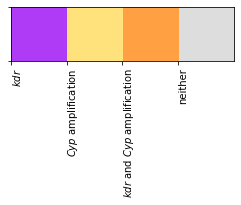

In [71]:
# palette
flat = ["#af3bf7",  "#ffe27c", "#ffa042","#dddddd"]
palette = sns.color_palette(flat, n_colors=len(pyr_nm))
sns.palplot(palette)
_ = plt.gca().set_xticklabels(pyr_nm, rotation='vertical', ha='left')

In [81]:
#merge all the useful info
plotting_df = pd.merge(sites_with_many_samples, kdr_call, on='site_id')

In [84]:
plotting_df

latitude  longitude                       country  nsamples  \
site_id                                                                 
0       -23.716000  35.299000                    Mozambique        74   
1       -15.933000  34.755000                        Malawi        41   
2       -12.857087  45.137435                       Mayotte        23   
3        -8.884000  13.302000                        Angola        81   
4        -4.940000  38.948000                      Tanzania        43   
5        -3.511000  39.909000                         Kenya        86   
6        -3.482000  37.308000                      Tanzania        40   
7        -1.962000  31.651000                      Tanzania       170   
8        -1.431000  34.199000                      Tanzania        47   
9        -0.751000  29.701000                        Uganda        96   
10        0.384000   9.455000                         Gabon        69   
11        0.770000  34.026000                        Uganda       193   
19        3.700000   8.700000                         Bioko        10   
23        3.972000  11.516000                      Cameroon        10   
26        4.283000  21.017000  Democratic Republic of Congo        76   
28        4.341000  13.558000                      Cameroon       110   
29        4.367000  18.583000      Central African Republic        73   
30        4.777000  13.844000                      Cameroon        96   
31        4.912000  -1.774000                         Ghana        24   
34        5.609000  -1.549000                         Ghana        25   
35        5.668000  -0.219000                         Ghana        27   
36        5.726000  10.868000                      Cameroon        12   
37        5.747000  14.442000                      Cameroon        97   
39        5.898000  -4.823000                 Cote d'Ivoire        80   
40        6.094000  -0.261000                         Ghana        24   
60        8.480000  -9.530000                        Guinea        74   
72        9.280000 -10.030000                        Guinea        62   
95       10.830000  -7.810000                          Mali        63   
96       11.150000  -4.235000                  Burkina Faso        77   
97       11.233000  -4.472000                  Burkina Faso       128   
98       11.235000  -4.535000                  Burkina Faso        78   
99       11.470000  -8.330000                          Mali        31   
100      11.880000  -8.450000                          Mali        23   
101      11.891000 -15.582000                 Guinea-Bissau        60   
102      11.957000 -15.649000                 Guinea-Bissau        33   
103      12.060000  -1.170000                  Burkina Faso        13   
109      12.890000  -8.150000                          Mali        40   
110      12.900000  -8.160000                          Mali        13   
112      13.210000  -5.900000                          Mali        20   
113      13.417000 -16.033000                    The Gambia        19   
114      13.550000 -15.900000                    The Gambia        74   
116      13.567000 -14.917000                    The Gambia       174   
117      13.583000 -15.900000                    The Gambia        11   

         offset_lat  offset_lon  both  cyp  kdr  none  
site_id                                                
0              1.50        2.00     0   13    0    61  
1              1.50       -1.50     0   16    0    25  
2              1.50       -1.50     0    5    0    18  
3             -2.00       -1.50    16    1   62     2  
4             -1.60       -1.60     3    6   18    16  
5              0.50        2.50     4    1   45    36  
6             -1.50       -0.90     0    2    0    38  
7             -2.00        1.00    31   19    1   119  
8             -2.00        1.00     0    6    0    41  
9              1.30       -1.00    87    0    8     1  
10            -3.20       -1.20     2    0   67     

In [83]:
for site, row in plotting_df.iterrows():
    print(site, row.longitude)

0 35.299
1 34.755
2 45.1374347826087
3 13.302
4 38.948
5 39.909
6 37.308
7 31.651
8 34.199
9 29.701
10 9.455
11 34.026
19 8.7
23 11.515999999999998
26 21.017
28 13.558
29 18.583
30 13.844
31 -1.774
34 -1.5490000000000002
35 -0.219
36 10.868
37 14.442
39 -4.823
40 -0.261
60 -9.53
72 -10.03
95 -7.81
96 -4.235
97 -4.472
98 -4.535
99 -8.33
100 -8.45
101 -15.582
102 -15.649
103 -1.17
109 -8.15
110 -8.16
112 -5.9
113 -16.033
114 -15.9
116 -14.917
117 -15.9


## Define a function to plot the sites

In [123]:
def plot_map(label_countries=True, pie_scale_factor=0.01):
    
    subplot_kw = dict(projection=ccrs.PlateCarree())
    # figsize here is the entire figure size in inches, reduced later by bbox_inches
    # This dpi setting affects the display size of the figure in the notebook
    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw=subplot_kw, dpi=150)
    ax.add_feature(cfeature.LAND, linewidth=1, zorder=1, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=2, edgecolor='gray')
    
    # For each site, plot the site marker or pie
    for site, metadata in plotting_df.iterrows():
        lon = metadata.longitude
        lat = metadata.latitude
        nsamples = metadata.nsamples
          
        # Get the centre offsets for this site
        offset_lon = metadata.offset_lon
        offset_lat = metadata.offset_lat

        # Calculate the pie's centre (offset) and radius (scaled)
        centre = (lon + offset_lon, lat + offset_lat)
        radius = np.sqrt(nsamples * pie_scale_factor)

        # Get the species calls for this site
        both = metadata.both
        cyp = metadata.cyp
        kdr = metadata.kdr
        none = metadata.none

        # Add a circle around the pie
        ax.add_patch(plt.Circle(xy=centre, radius=radius, edgecolor='k', zorder=5, lw=2))

        # Add the pie
        ax.pie([kdr, cyp, both, none], wedgeprops=dict(zorder=7) , colors=palette, center=centre, radius=radius)

        # If either of the offsets aren't 0, then plot a line from the site center to the pie centre
        if offset_lat != 0 or offset_lon != 0:
            ln2, = ax.plot([lon, lon + offset_lon],[lat, lat + offset_lat], 'k', lw=1, zorder=5)
            ln2.set_solid_capstyle('round')


        # If option to label the countries
        if label_countries:

            for country, metadata in country_metadata.iterrows():

                # Calculate the offset centre for the country label
                lon = metadata['longitude'] + metadata['offset_lon']
                lat = metadata['latitude'] + metadata['offset_lat']

                # If there is no corresponding multiline country then default
                long_label = country_names_as_multiline.get(country, country)

                # Add the text
                country_label = plt.text(lon, lat, long_label, fontsize=6, ha='center', zorder=10)
                country_label.set_path_effects([PathEffects.withStroke(linewidth=1.5, foreground='w')])


    # Legends
    
    # Cover up islands under the legend, e.g. Ascension Island, using a white rectangle 
    ax.add_patch(patches.Rectangle((-14.5,-8.5), 1, 1 , linewidth=1, edgecolor='w', facecolor='w', zorder=3))
            
    ## Species colour legend
    plt.text(-21.7, -3, 'Pyrethroid resistance genotype', fontsize=7, fontweight='bold')
    swatch_y = -5.4
    swatch_text_y = -6
    for i in range(0, 4):
        plt.plot([-18.5, -21], [swatch_y, swatch_y], color=flat[i], lw=7, zorder=11, solid_capstyle='round')
        plt.text(-17, swatch_text_y, s=pyr_nm[i], fontsize=7 )
        swatch_y -= 2.5
        swatch_text_y -= 2.5

    # Sample size legend
    plt.text(-21.7, -19, 'Sample size', fontsize=7, fontweight='bold')
    # Markers of same size as circles (below) used for spacing, hidden by alpha
    l1 = Line2D([], [], marker = 'o', markersize=4.9, markerfacecolor='k', color='w', alpha=0) 
    l2 = Line2D([], [], marker = 'o', markersize=8.5, markerfacecolor='k', color='w', alpha=0) 
    l3 = Line2D([], [], marker = 'o', markersize=11.3, markerfacecolor='k', color='w', alpha=0)
    labelz = [f"n=10", " n=50", "  n=100"]
    leg = ax.legend([l1, l2, l3], labelz, ncol=3, frameon=False, fontsize=6.5, handlelength=1, loc=3,
                    borderpad=1.6, handletextpad=0.6, bbox_to_anchor=(-0.05, 0.0))
    # lw=2 to match the circles added around the pies
    ax.add_patch(plt.Circle(xy=(-16.6,-21.3), radius=np.sqrt(10 * pie_scale_factor), facecolor='k', zorder=12, lw=2))
    ax.add_patch(plt.Circle(xy=(-7.3,-21.3), radius=np.sqrt(50 * pie_scale_factor), facecolor='k', zorder=12, lw=2))
    ax.add_patch(plt.Circle(xy=(3.4,-21.3), radius=np.sqrt(100 * pie_scale_factor), facecolor='k', zorder=12, lw=2))

    # This needs to be near the end
    ax.set_extent([-23, 47, -21, 16])
    
    # `bbox_inches='tight'` only saves a tight bounding box around the figure, otherwise surrounding white-space as per figsize
    # DPI set as a precaution, in case bitmaps are included in the SVG
    fig.savefig('GEM_pyr_ir_map.svg', bbox_inches='tight', dpi=300)
    fig.savefig('GEM_pyr_ir_map.jpg', bbox_inches='tight', dpi=300)

    
    return ax

## Produce the map using the plot function

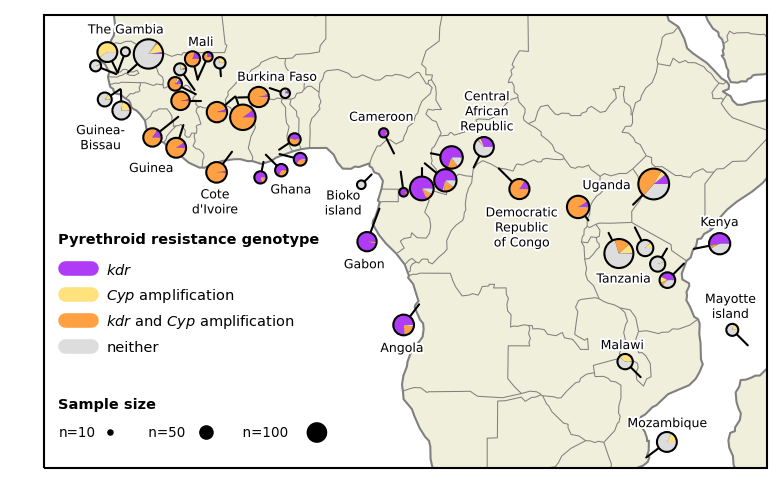

In [124]:
ax = plot_map()